In [94]:
import numpy as np 
import matplotlib.pyplot as plt 
import nibabel as nib
from skimage.measure import label, regionprops 
from scipy.ndimage import binary_dilation

Loading Data 

In [95]:
def load_nifti(filepath):
    return nib.load(filepath)

Shape: (512, 512, 216) Spacing: (np.float32(0.869141), np.float32(0.869141), np.float32(2.0))


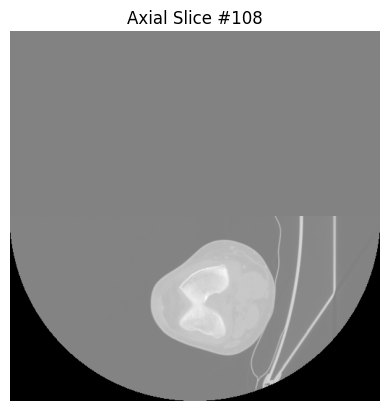

In [98]:
ct_image = load_nifti("3702_left_knee.nii.gz") 
ct_data = ct_image.get_fdata()
spacing = ct_image.header.get_zooms()
print("Shape:", ct_data.shape, "Spacing:", spacing)

mid_axial = ct_data.shape[2] // 2
plt.imshow(ct_data[:, :, mid_axial], cmap="gray")
plt.title(f"Axial Slice #{mid_axial}")
plt.axis('off')
plt.show()

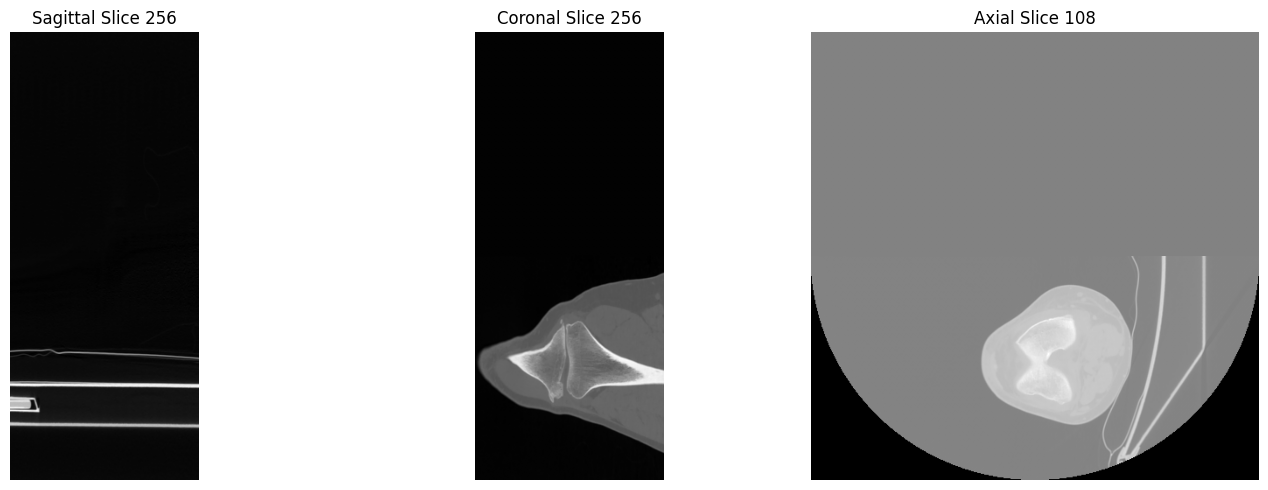

In [99]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Axial (horizontal) view
axial_idx = ct_data.shape[2] // 2
axs[2].imshow(ct_data[:, :, axial_idx], cmap="gray")
axs[2].set_title(f"Axial Slice {axial_idx}")
axs[2].axis('off')

# Coronal (frontal) view
coronal_idx = ct_data.shape[1] // 2
axs[1].imshow(ct_data[:, coronal_idx, :], cmap="gray")
axs[1].set_title(f"Coronal Slice {coronal_idx}")
axs[1].axis('off')

# Sagittal (side) view
sagittal_idx = ct_data.shape[0] // 2
axs[0].imshow(ct_data[sagittal_idx, :, :], cmap="gray")
axs[0].set_title(f"Sagittal Slice {sagittal_idx}")
axs[0].axis('off')

plt.tight_layout()
plt.show()


Visualize all useful axial slices 

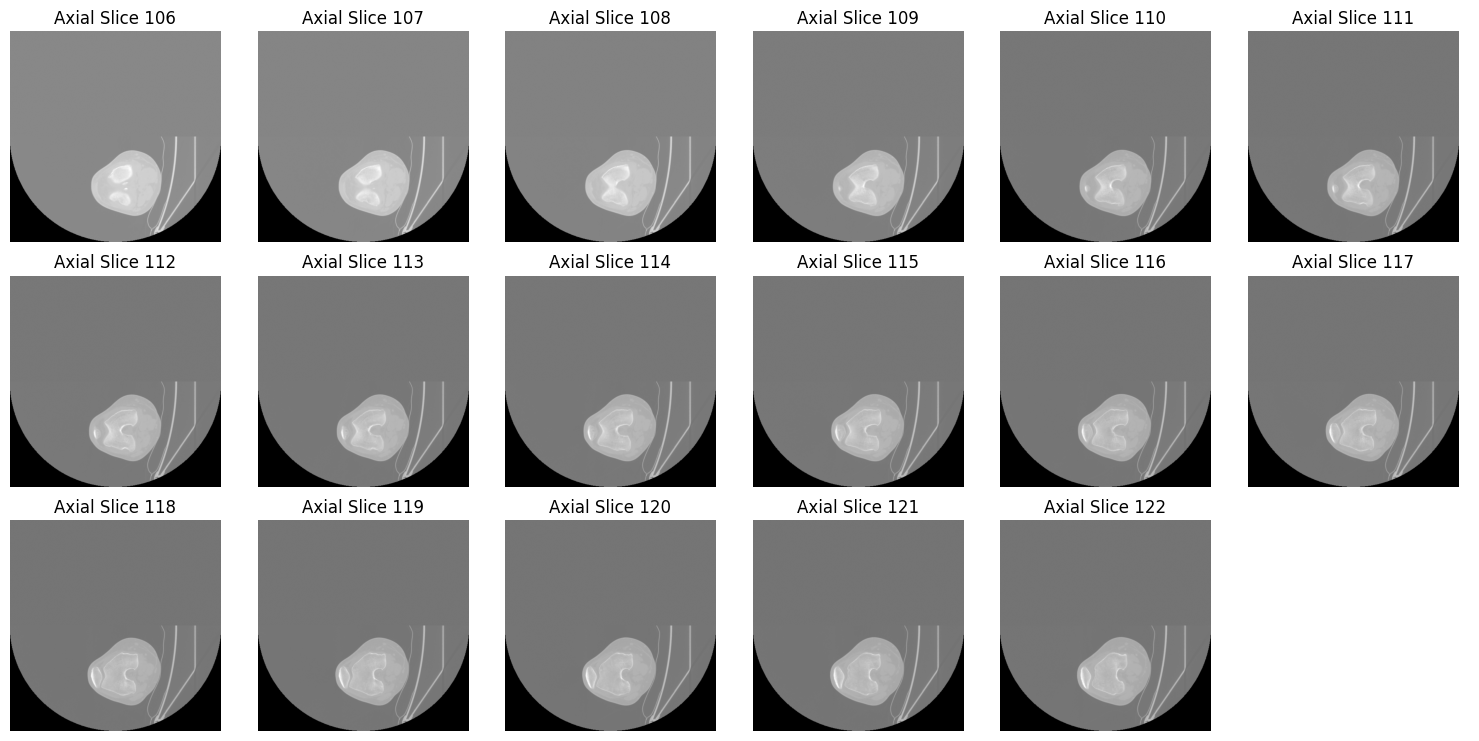

In [100]:
start = 106
end = 123
num_slices = end - start

cols = 6  
rows = (num_slices + cols - 1) // cols  # Calculate required number of rows

fig, axs = plt.subplots(rows, cols, figsize=(15, 2.5 * rows))

for i, z in enumerate(range(start, end)):
    row = i // cols
    col = i % cols
    ax = axs[row, col] if rows > 1 else axs[col]
    ax.imshow(ct_data[:, :, z], cmap='gray')
    ax.set_title(f"Axial Slice {z}")
    ax.axis('off')

# Turn off unused subplots if any
for j in range(i + 1, rows * cols):
    row = j // cols
    col = j % cols
    ax = axs[row, col] if rows > 1 else axs[col]
    ax.axis('off')

plt.tight_layout()
plt.show()

Visualize all useful coronal slices

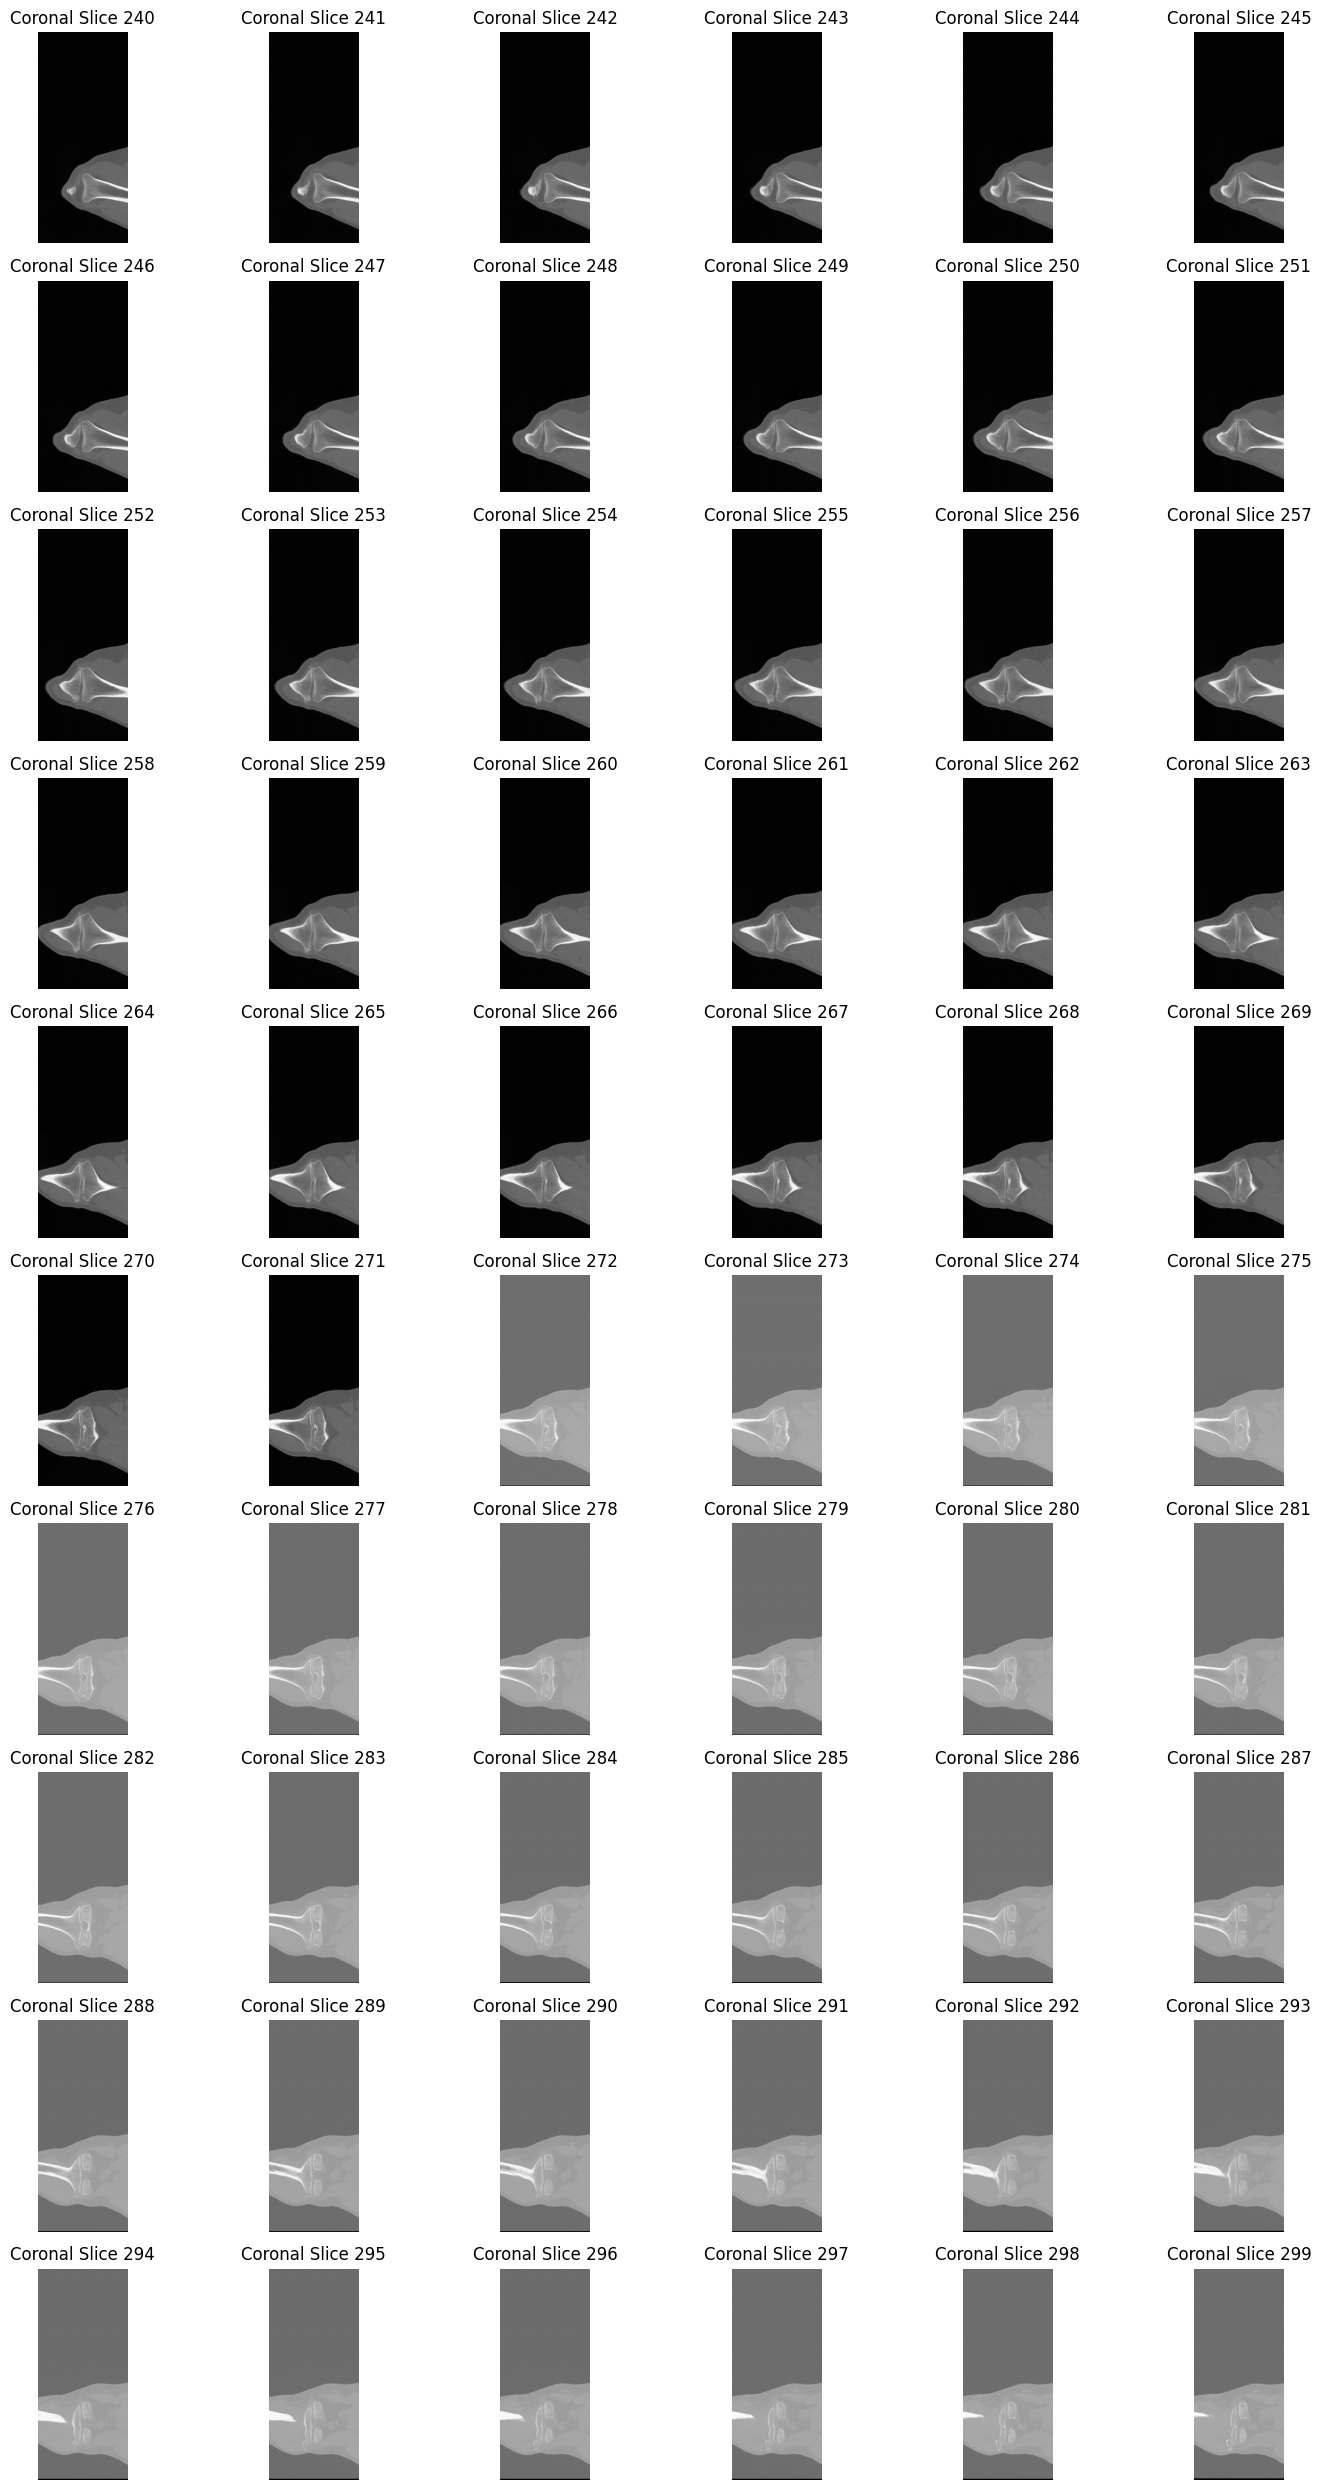

In [101]:
start = 240
end = 300
num_slices = end - start

cols = 6  
rows = (num_slices + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(15, 2.5 * rows))

for i, y in enumerate(range(start, end)):
    row = i // cols
    col = i % cols
    ax = axs[row, col] if rows > 1 else axs[col]
    ax.imshow(ct_data[:, y, :], cmap='gray')
    ax.set_title(f"Coronal Slice {y}")
    ax.axis('off')

# Turn off unused subplots if any
for j in range(i + 1, rows * cols):
    row = j // cols
    col = j % cols
    ax = axs[row, col] if rows > 1 else axs[col]
    ax.axis('off')

plt.tight_layout()
plt.show()

Visualize all useful sagittal slices

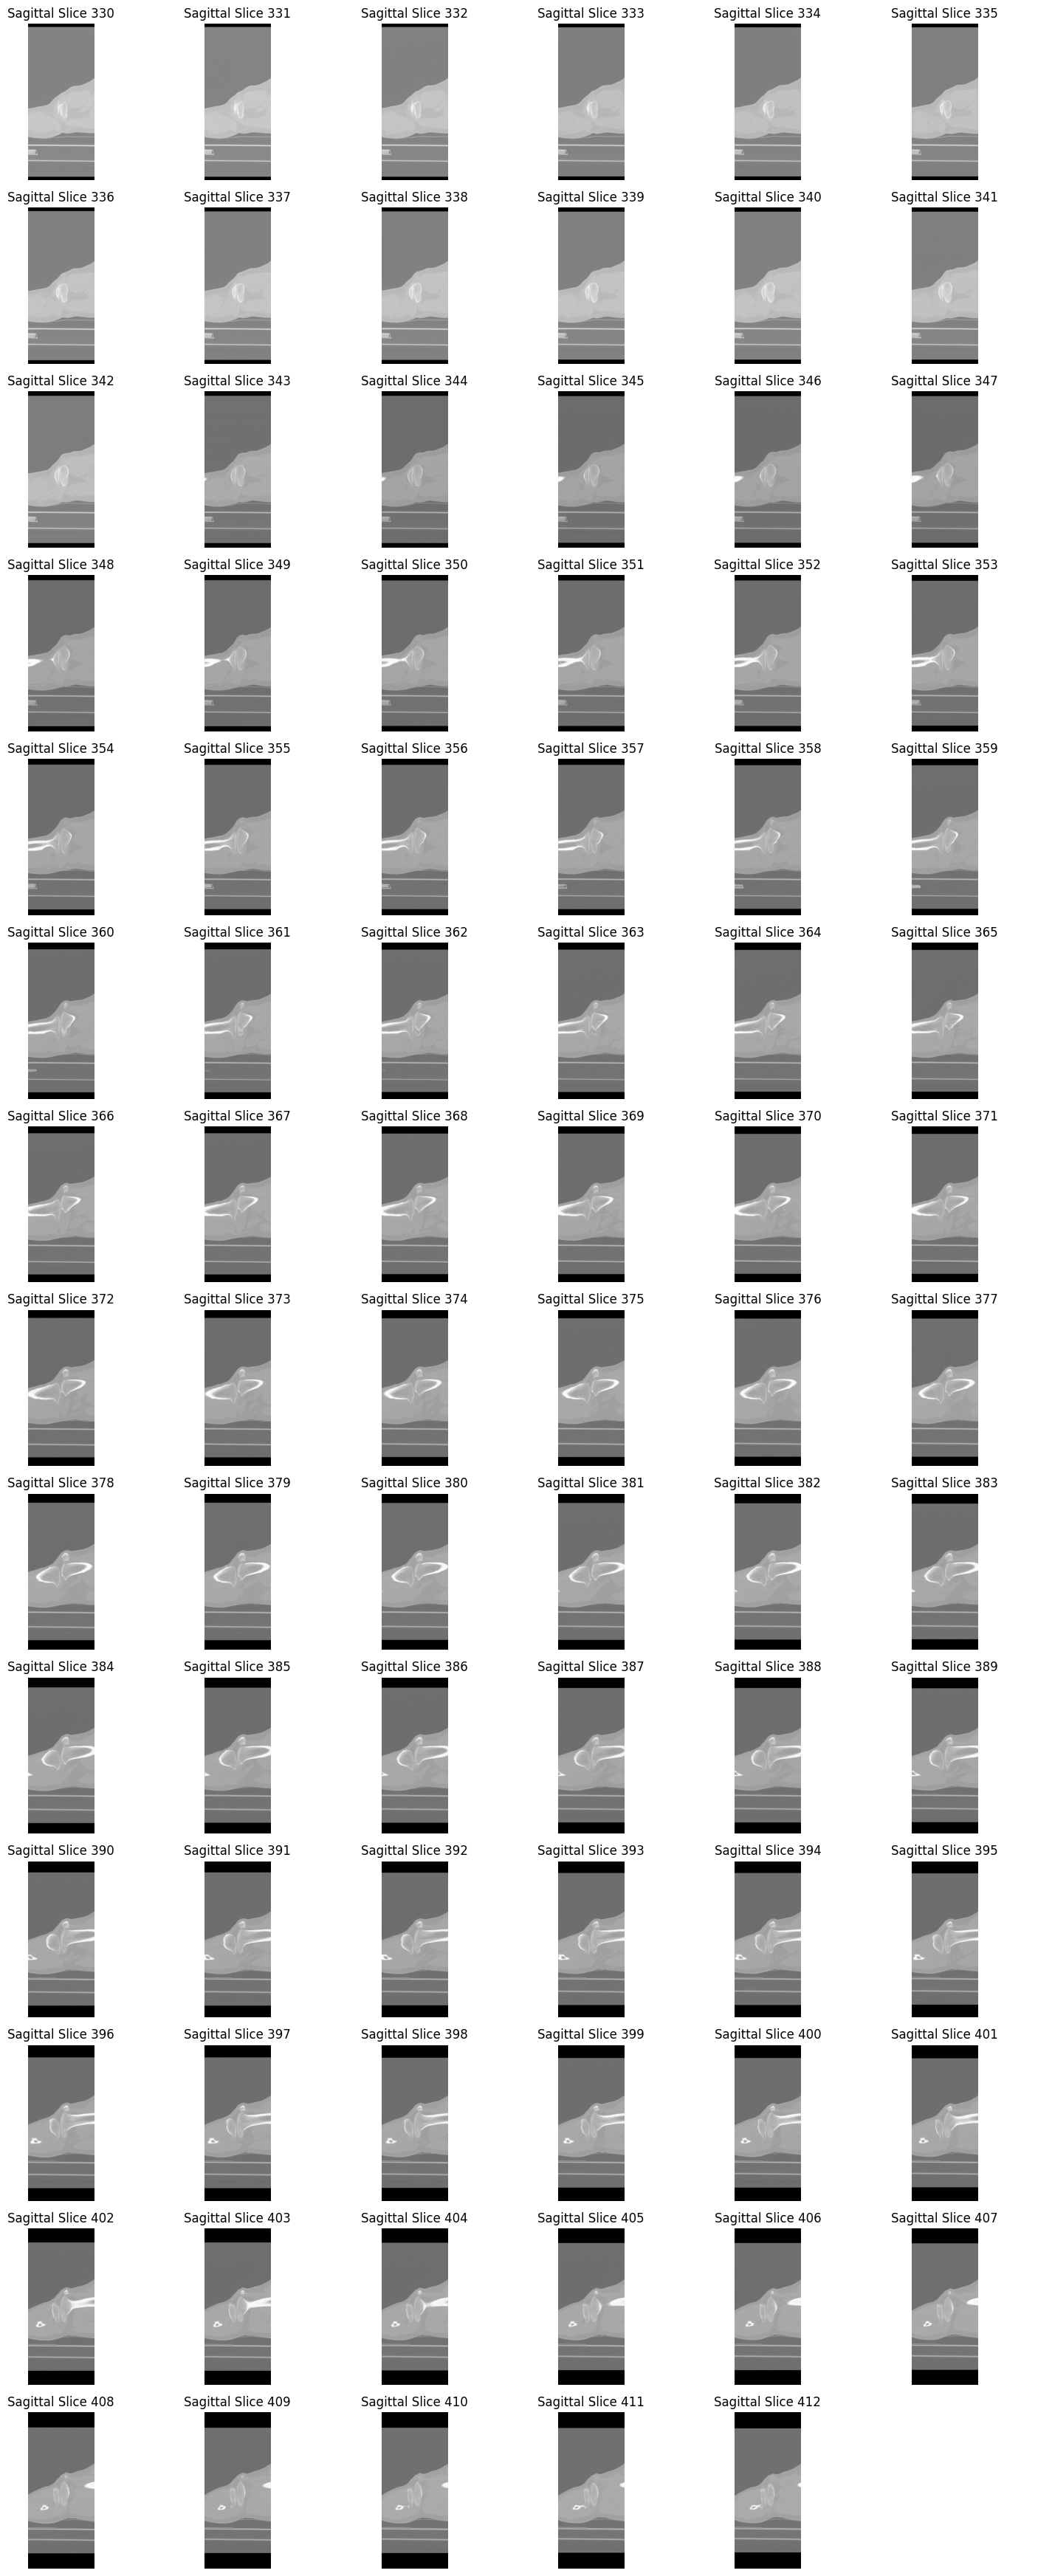

In [102]:
start = 330
end = 413
num_slices = end - start

cols = 6  
rows = (num_slices + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(15, 2.5 * rows))

for i, x in enumerate(range(start, end)):
    row = i // cols
    col = i % cols
    ax = axs[row, col] if rows > 1 else axs[col]
    ax.imshow(ct_data[x, :, :], cmap='gray')
    ax.set_title(f"Sagittal Slice {x}")
    ax.axis('off')

# Turn off unused subplots if any
for j in range(i + 1, rows * cols):
    row = j // cols
    col = j % cols
    ax = axs[row, col] if rows > 1 else axs[col]
    ax.axis('off')

plt.tight_layout()
plt.show()

Bone Segmentation


In [103]:
def threshold_segmentation(data, lower=200, upper=2000):
    mask = np.logical_and(data >= lower, data <= upper)
    return mask.astype(np.uint8)

bone_mask = threshold_segmentation(ct_data)
nib.save(nib.Nifti1Image(bone_mask, ct_image.affine), "3702_left_knee_mask.nii.gz")


Contour Expansion

In [104]:
def expand_mask(mask, spacing, expansion_mm=2):
    voxel_radius = int(expansion_mm / spacing[0])  # convert mm to voxel count
    expanded = binary_dilation(mask, iterations=voxel_radius)
    return expanded.astype(np.uint8)

expanded_2mm = expand_mask(bone_mask, spacing, 2)
expanded_4mm = expand_mask(bone_mask, spacing, 4)

nib.save(nib.Nifti1Image(expanded_2mm, ct_image.affine), "expanded_2mm.nii.gz")
nib.save(nib.Nifti1Image(expanded_4mm, ct_image.affine), "expanded_4mm.nii.gz")


Slice with most segmented pixels: 118


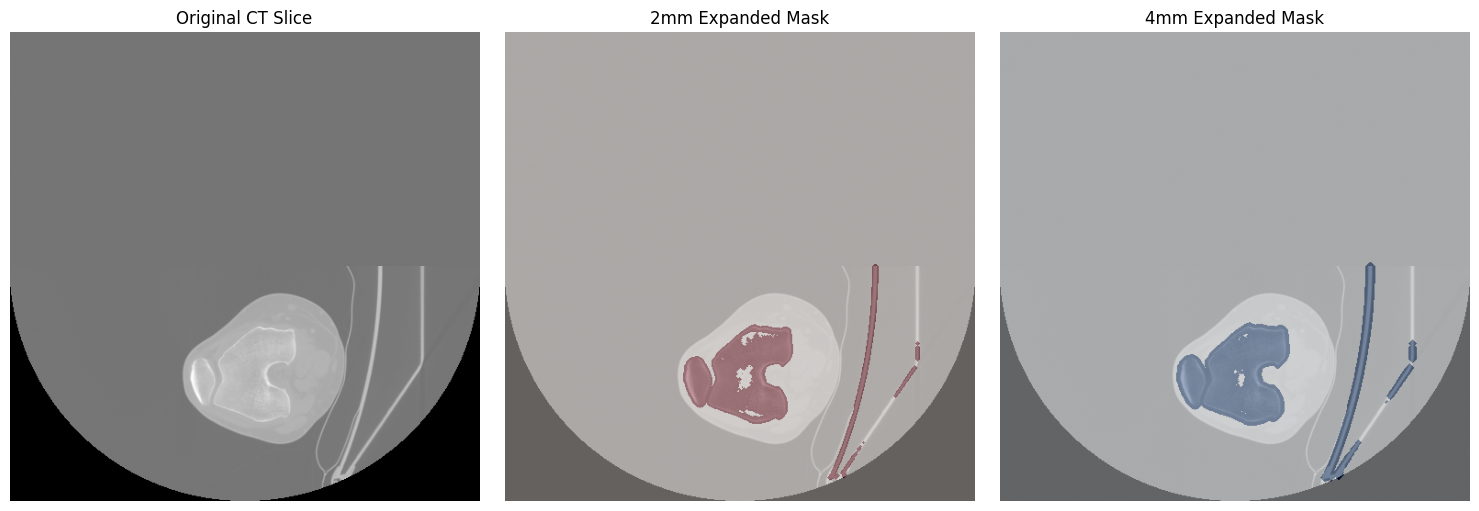

In [106]:
#For Axial
slice_sums = [np.sum(expanded_2mm[:, :, i]) for i in range(expanded_2mm.shape[2])]
best_slice = np.argmax(slice_sums)
print("Slice with most segmented pixels:", best_slice)


z = best_slice 

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(ct_data[:, :, z], cmap='gray')
axs[0].set_title("Original CT Slice")
axs[0].axis('off')

# Overlay 2mm expansion mask
axs[1].imshow(ct_data[:, :, z], cmap='gray')
axs[1].imshow(expanded_2mm[:, :, z], cmap='Reds', alpha=0.4)
axs[1].set_title("2mm Expanded Mask")
axs[1].axis('off')

# Overlay 4mm expansion mask
axs[2].imshow(ct_data[:, :, z], cmap='gray')
axs[2].imshow(expanded_4mm[:, :, z], cmap='Blues', alpha=0.4)
axs[2].set_title("4mm Expanded Mask")
axs[2].axis('off')

plt.tight_layout()
plt.show()

Coronal Slice with most segmented pixels: 400


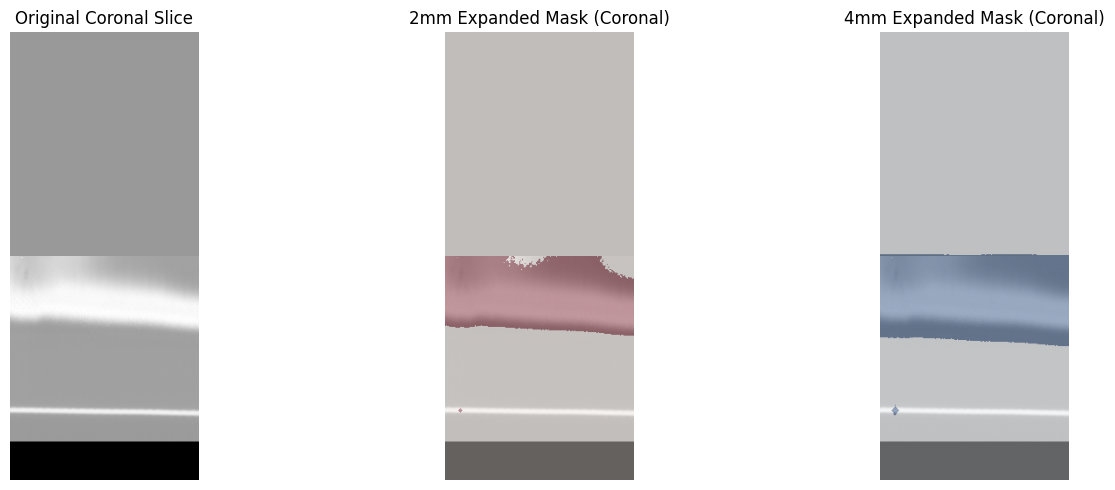

In [107]:
# For Coronal
slice_sums = [np.sum(expanded_2mm[:, i, :]) for i in range(expanded_2mm.shape[1])]
best_slice = np.argmax(slice_sums)
print("Coronal Slice with most segmented pixels:", best_slice)

y = best_slice  # coronal index

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(ct_data[:, y, :], cmap='gray')
axs[0].set_title("Original Coronal Slice")
axs[0].axis('off')

axs[1].imshow(ct_data[:, y, :], cmap='gray')
axs[1].imshow(expanded_2mm[:, y, :], cmap='Reds', alpha=0.4)
axs[1].set_title("2mm Expanded Mask (Coronal)")
axs[1].axis('off')

axs[2].imshow(ct_data[:, y, :], cmap='gray')
axs[2].imshow(expanded_4mm[:, y, :], cmap='Blues', alpha=0.4)
axs[2].set_title("4mm Expanded Mask (Coronal)")
axs[2].axis('off')

plt.tight_layout()
plt.show()


Sagittal Slice with most segmented pixels: 395


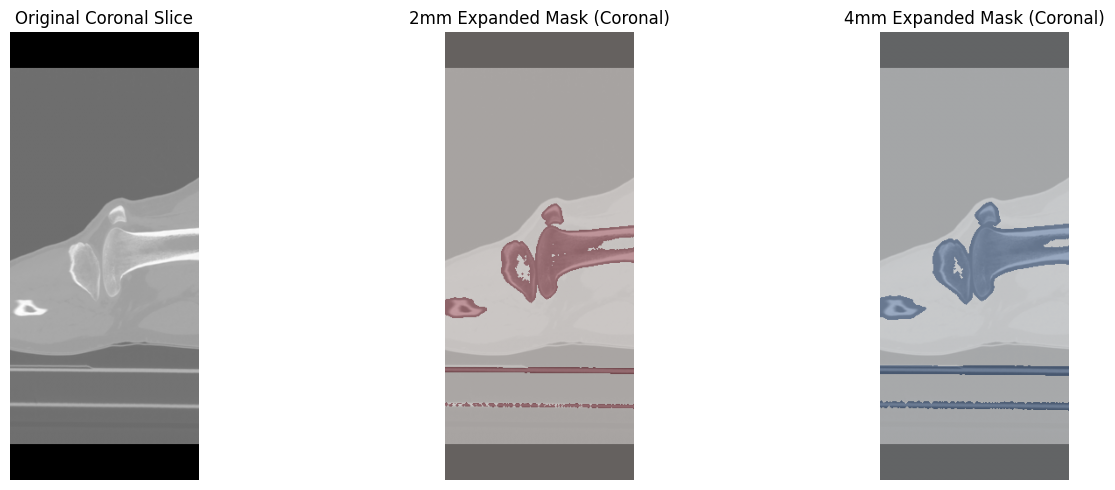

In [108]:
# For Sagittal
slice_sums = [np.sum(expanded_2mm[i, :, :]) for i in range(expanded_2mm.shape[0])]
best_slice = np.argmax(slice_sums)
print("Sagittal Slice with most segmented pixels:", best_slice)

x = best_slice 

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(ct_data[x, :, :], cmap='gray')
axs[0].set_title("Original Coronal Slice")
axs[0].axis('off')

axs[1].imshow(ct_data[x, :, :], cmap='gray')
axs[1].imshow(expanded_2mm[x, :, :], cmap='Reds', alpha=0.4)
axs[1].set_title("2mm Expanded Mask (Coronal)")
axs[1].axis('off')

axs[2].imshow(ct_data[x, :, :], cmap='gray')
axs[2].imshow(expanded_4mm[x, :, :], cmap='Blues', alpha=0.4)
axs[2].set_title("4mm Expanded Mask (Coronal)")
axs[2].axis('off')

plt.tight_layout()
plt.show()


Randomized Contour Adjustment

In [109]:
def randomized_mask(original, expanded, random_mm=1):
    mask = np.copy(original)
    difference = np.logical_and(expanded, np.logical_not(original))
    rand_field = np.random.rand(*mask.shape)
    mask[np.logical_and(difference, rand_field < 0.5)] = 1  # threshold controls randomness
    return mask.astype(np.uint8)

random_mask1 = randomized_mask(bone_mask, expanded_2mm, 1)
random_mask2 = randomized_mask(bone_mask, expanded_2mm, 2)

nib.save(nib.Nifti1Image(random_mask1, ct_image.affine), "random_mask1.nii.gz")
nib.save(nib.Nifti1Image(random_mask2, ct_image.affine), "random_mask2.nii.gz")


Tibia Landmark Detection

In [110]:
def find_lowest_points(mask, axis=2):
    labeled = label(mask)
    props = regionprops(labeled)
    largest = max(props, key=lambda r: r.area)
    coords = largest.coords
    coords_sorted = sorted(coords, key=lambda c: c[axis])  # sort by z-axis

    midpoint = np.mean([c[1] for c in coords_sorted])
    medial = min(coords_sorted, key=lambda c: c[1] if c[1] < midpoint else np.inf)
    lateral = min(coords_sorted, key=lambda c: -c[1] if c[1] > midpoint else np.inf)

    return medial, lateral

masks = {
    "original": bone_mask,
    "expanded_2mm": expanded_2mm,
    "expanded_4mm": expanded_4mm,
    "random_mask1": random_mask1,
    "random_mask2": random_mask2
}

with open("landmarks.txt", "w") as f:
    for name, mask in masks.items():
        medial, lateral = find_lowest_points(mask)
        f.write(f"{name} - Medial: {medial}, Lateral: {lateral}\n")


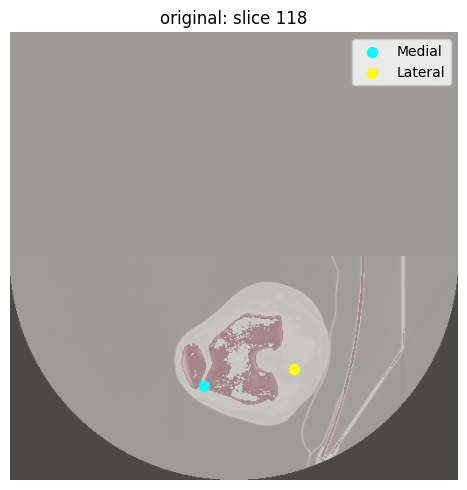

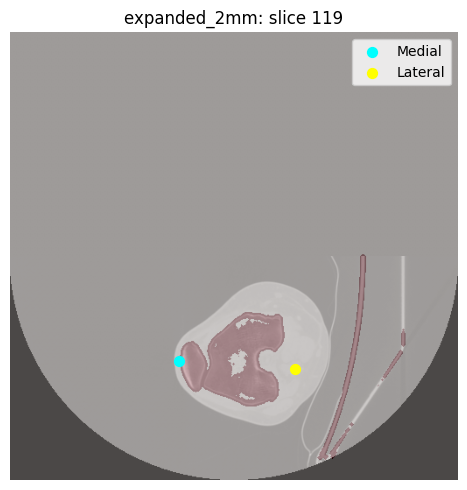

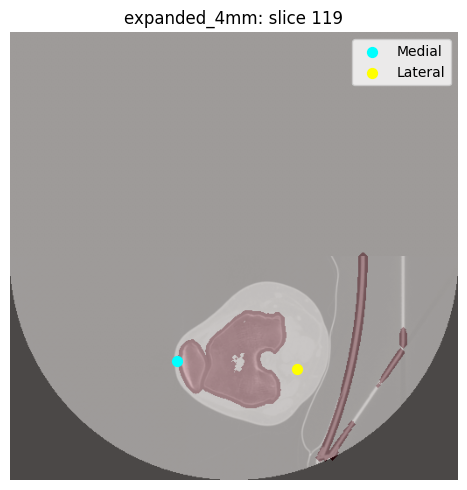

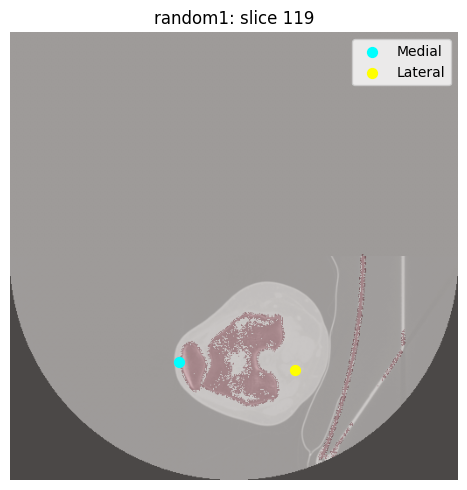

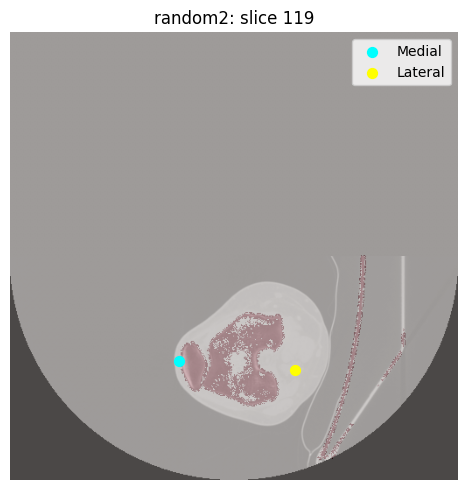

In [ ]:
for name, mask in masks.items():
    medial, lateral = find_lowest_points(mask)
    z_idx = medial[2]

    fig, ax = plt.subplots(1,1, figsize=(5,5))
    ax.imshow(ct_data[:, :, z_idx], cmap="gray")
    ax.imshow(mask[:, :, z_idx], cmap="Reds", alpha=0.3)

    # plot medial & lateral points
    # note: coords are (i=row, j=col, k=slice)
    ax.scatter(medial[1],  medial[0],  c='cyan', s=50, label='Medial')
    ax.scatter(lateral[1], lateral[0], c='yellow', s=50, label='Lateral')

    ax.set_title(f"{name}: slice {z_idx}")
    ax.axis('off')
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()